# 1. Abstract

We are focusing on classifying a person as a cocaine-user or non-user based on varying demographic features. 

# 2. Introduction

# 3. x

In [177]:
#### Cleaning the dataset:
import pandas as pd
import seaborn as sn
import numpy as np

# Importing the dataset:
drugs = pd.read_csv('/Users/nickcohn24/Desktop/Resume-Projects/Classification Modeling Project/drug_consumption.csv')

# encoding the cocaine category to represent a user (1) or non-user (0)
drugs['Cocaine_use'] = np.where(drugs['Coke']=='CL0', 0, 1)

# dropping unnecessary columns
column_drops = ['ID', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 
                'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 
                'Mushrooms', 'Nicotine', 'Semer', 'VSA']
drugs = drugs.drop(columns=column_drops, axis=1)

# predictors (X) and response (y)
X = drugs.drop(columns='Cocaine_use', axis=1)
y = drugs['Cocaine_use']

# checking if scaling is necessary for KNN (it wasn't)
print(X.describe())

# checking the proportion of users to non-users
print(drugs['Cocaine_use'].value_counts(normalize=True))


              Age       Gender    Education      Country    Ethnicity  \
count  1885.00000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.03461    -0.000256    -0.003806     0.355542    -0.309577   
std       0.87836     0.482588     0.950078     0.700335     0.166226   
min      -0.95197    -0.482460    -2.435910    -0.570090    -1.107020   
25%      -0.95197    -0.482460    -0.611130    -0.570090    -0.316850   
50%      -0.07854    -0.482460    -0.059210     0.960820    -0.316850   
75%       0.49788     0.482460     0.454680     0.960820    -0.316850   
max       2.59171     0.482460     1.984370     0.960820     1.907250   

            Nscore       Escore       Oscore       Ascore       Cscore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.000047    -0.000163    -0.000534    -0.000245    -0.000386   
std       0.998106     0.997448     0.996229     0.997440     0.997523   
min      -3.464360    -3.273930    -3.273930  

In [178]:
#### Cross-Validation Metrics for Baseline Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


# Logistic Regression
logr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logr_accuracy = cross_val_score(logr, X, y, cv=5, scoring='accuracy')
logr_auc = cross_val_score(logr, X, y, cv=5, scoring='roc_auc')
print(f'Logistic Regression CV Accuracy: {np.mean(logr_accuracy)}')
print(f'Logistic Regression CV AUC: {np.mean(logr_auc)}')


# Decision Tree
dtree = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
dtree_accuracy = cross_val_score(dtree, X, y, cv=5, scoring='accuracy')
dtree_auc = cross_val_score(dtree, X, y, cv=5, scoring='roc_auc')
print(f'Decision Tree CV Accuracy: {np.mean(dtree_accuracy)}')
print(f'Decision Tree CV AUC: {np.mean(dtree_auc)}')

# K-Nearest-Neighbors
KNN = KNeighborsClassifier(n_neighbors=5)
KNN_accuracy = cross_val_score(KNN, X, y, cv=5, scoring='accuracy')
KNN_auc = cross_val_score(KNN, X, y, cv=5, scoring='roc_auc')
print(f'KNN CV Accuracy: {np.mean(KNN_accuracy)}')
print(f'KNN CV AUC: {np.mean(KNN_auc)}')


# XGBoost
XGB_full_weights = sum(y_train==0) / sum(y_train==1)
xgb = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=XGB_full_weights) # logloss since binary classification
xgb_accuracy = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
xgb_auc = cross_val_score(xgb, X, y, cv=5, scoring='roc_auc')
print(f'XGBoost CV Accuracy: {np.mean(xgb_accuracy)}')
print(f'XGBoost CV AUC: {np.mean(xgb_auc)}')


Logistic Regression CV Accuracy: 0.6557029177718834
Logistic Regression CV AUC: 0.7176020447164835
Decision Tree CV Accuracy: 0.6546419098143237
Decision Tree CV AUC: 0.7073183277255676
KNN CV Accuracy: 0.6541114058355438
KNN CV AUC: 0.6932792910855344
XGBoost CV Accuracy: 0.6620689655172413
XGBoost CV AUC: 0.7193112216884141


Logistic regression and XGBoost performed significntly better than the other models in terms of both accuracy and AUC. XGBoost performed the best on both metrics, suggesting it to be the more appropriate model' however, we will still move forward with both the logistic regression model and the XGBoost model. 

In [179]:
#### Hyperparameter tuning with GridSearch
from sklearn.model_selection import GridSearchCV, train_test_split


# splitting into train/test sets for fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.2, random_state=42, stratify=y)


# Logistic Regression
logr_paramgrid = {'C':[0.01, 0.1, 1, 10], 'solver':['liblinear','lbfgs'],
                'max_iter':[1000]}
logr_grid = GridSearchCV(logr, param_grid=logr_paramgrid,
                    scoring='roc_auc', cv=5, n_jobs=-1)
logr_grid.fit(X_train, y_train)
print('Optimal Parameters for Logistic Regression: ', logr_grid.best_params_)
print('Best AUC Score for Logistic Regression: ', logr_grid.best_score_)

# XGBoost
xgb_paramgrid = {'n_estimators':[50, 100, 150], 'max_depth':[3, 5, 7],
                'learning_rate':[0.01, 0.1, 0.2], 'subsample':[0.8, 1.0]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_paramgrid, 
                        scoring='roc_auc', cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print('Optimal Parameters for XGBoost: ', xgb_grid.best_params_)
print('Best AUC Score for XGBoost: ', xgb_grid.best_score_)







Optimal Parameters for Logistic Regression:  {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
Best AUC Score for Logistic Regression:  0.7282863480064048
Optimal Parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best AUC Score for XGBoost:  0.7617036118329528


In [180]:
#### Fitting Proposed Models with the Optimal Parameters


# Logistic Regression
optimal_logr = LogisticRegression(C=1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42)
optimal_logr.fit(X_train, y_train)

# XGBoost
neg = sum(y_train)
optimal_xgb = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, 
                            subsample=0.8, scale_pos_weight=XGB_full_weights, random_state=42, eval_metric='logloss')
optimal_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [181]:
#### Evaluating the Performances of Proposed Models
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


# Logistic regression
y_hat_logr = optimal_logr.predict(X_test)
y_prob_logr = optimal_logr.predict_proba(X_test)[:, 1]
print('Logistic Regression Test Accuracy : ', accuracy_score(y_test, y_hat_logr))
print('Logistic Regression Test AUC : ', roc_auc_score(y_test, y_prob_logr))
print(classification_report(y_test, y_hat_logr))

# XGBoost
y_hat_xgb = optimal_xgb.predict(X_test)
y_prob_xgb = optimal_xgb.predict_proba(X_test)[:, 1]
print('XGBoost Full Test Accuracy : ', accuracy_score(y_test, y_hat_xgb))
print('XGBoost Full Test AUC : ', roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_hat_xgb))



Logistic Regression Test Accuracy :  0.6604774535809018
Logistic Regression Test AUC :  0.7041704597177969
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       208
           1       0.60      0.72      0.66       169

    accuracy                           0.66       377
   macro avg       0.67      0.67      0.66       377
weighted avg       0.67      0.66      0.66       377

XGBoost Full Test Accuracy :  0.6578249336870027
XGBoost Full Test AUC :  0.7374260355029587
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       208
           1       0.60      0.72      0.65       169

    accuracy                           0.66       377
   macro avg       0.66      0.66      0.66       377
weighted avg       0.67      0.66      0.66       377



The XGBoost model performed better in terms of both accuracy and AUC compared to the logistic regression model. While these metrics bely a moderate performance, drug-use is an inhernently hard variable to predict so our numbers are still decent. Therefore, we choose the XGBoost model as our final type of model.

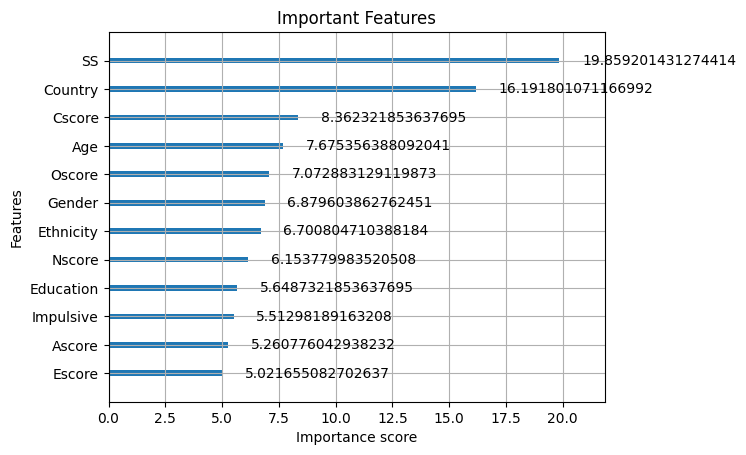

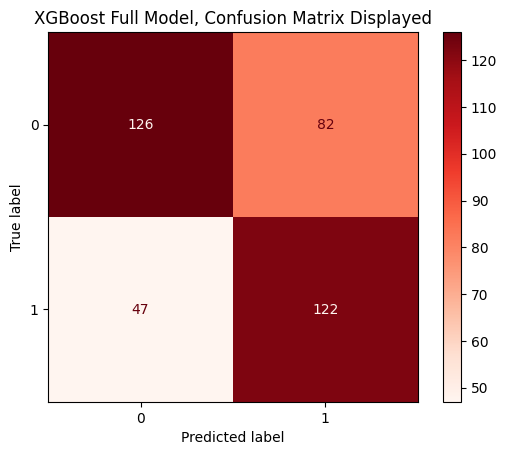

In [182]:
#### Checking if we can simplify/improve our XGBoost model
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# Feature Importance
plot_importance(optimal_xgb, importance_type='gain')
plt.title('Important Features')
plt.show()

# Confusion Matrix for False Positives/Negatives
cm = confusion_matrix(y_test, y_hat_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Reds')
plt.title("XGBoost Full Model, Confusion Matrix Displayed")
plt.show()


The features "SS" and "Country" are significantly important features with scores of 19 and 16 respectively, with "Cscore", "Age", and other features being only moderately important features. Due to this, we will attempt to retrain the model using only the four most important features (SS, Country, Cscore, Age). "Escore" and "Impulsive" were the least significant features. 

Our confusion matrix showed decent performance for correctly identifying cocaine users and non-users, with the model specifically performing better at correctly predicting which individuals have used cocaine. Our model also performed well by having a relatively low number of false positives/negatives, but the model performed specifically better when it came to false negatives. This is ideal since false negatives mean we are not detecting cocaine use when it is present.

In [183]:
#### Retraining the model based on only important features
from sklearn.model_selection import StratifiedKFold

# train/test sets split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, 
                test_size=0.2, random_state=42, stratify=y)
                
# reducing to only important features
X_reduced = drugs[['SS', 'Country', 'Cscore', 'Age']]
y = drugs['Cocaine_use']

# reduced model with optimal parameters
XGB_reduced_weights = sum(y_train==0) / sum(y_train==1)
xgb_reduced = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, 
                            subsample=0.8, scale_pos_weight=XGB_reduced_weights, random_state=42, eval_metric='logloss')

# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reduced_accuracy = cross_val_score(xgb_reduced, X_reduced, y, cv=cv, scoring='accuracy')
reduced_AUC = cross_val_score(xgb_reduced, X_reduced, y, cv=cv, scoring='roc_auc')

print(f'XGBoost Reduced CV Accuracy: {np.mean(reduced_accuracy)}')
print(f'XGBoost Reduced CV AUC: {np.mean(reduced_AUC)}')


XGBoost Reduced CV Accuracy: 0.680106100795756
XGBoost Reduced CV AUC: 0.7483885747738107


XGBoost Reduced Test Accuracy:  0.6631299734748011
XGBoost Reduced Test AUC:  0.7151797906235775
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       208
           1       0.61      0.71      0.65       169

    accuracy                           0.66       377
   macro avg       0.67      0.67      0.66       377
weighted avg       0.67      0.66      0.66       377



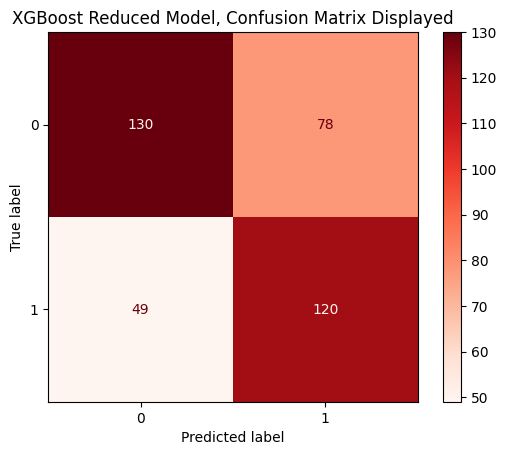

In [184]:
#### Evaluating the Reduced Model on the Test Set


# fitting the reduced model
xgb_reduced.fit(X_train, y_train)

# making predictions and evlauating metrics
y_hat_reduced = xgb_reduced.predict(X_test)
y_probs_reduced = xgb_reduced.predict_proba(X_test)[:, 1]
print('XGBoost Reduced Test Accuracy: ', accuracy_score(y_test, y_hat_reduced))
print('XGBoost Reduced Test AUC: ', roc_auc_score(y_test, y_probs_reduced))
print(classification_report(y_test, y_hat_reduced))

# confusion matrix for false positives/negatives, for the reduced XGBoost model
cm = confusion_matrix(y_test, y_hat_reduced)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Reds')
plt.title("XGBoost Reduced Model, Confusion Matrix Displayed")
plt.show()


The reduced model showed slightly better cross validation performance by having both a higher accuracy and AUC, but the full model performed better on the test set when it came to having a slightly lower accuracy but much higher AUC. 

For the confusion-matrices, while the number of true positives went up after reducing our model, the number of false negatives also went up. A lower amount of false negatives is relevant to out model since we would prefer suspecting too many people of cocaine use than letting cocaine users slip away and remain undetected.  

Based on these results, we choose the full XGboost model to be our final model. 

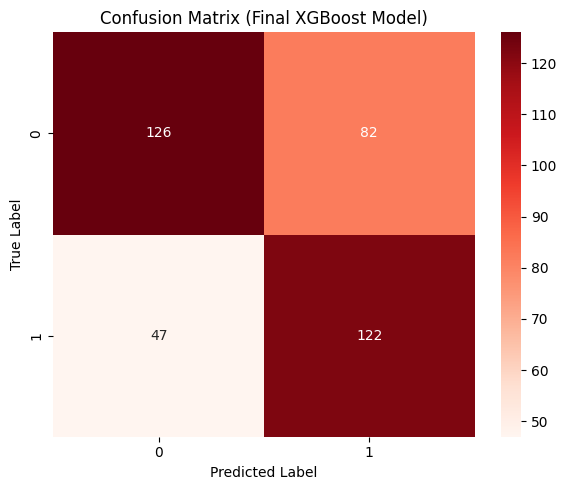

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       208
           1       0.60      0.72      0.65       169

    accuracy                           0.66       377
   macro avg       0.66      0.66      0.66       377
weighted avg       0.67      0.66      0.66       377



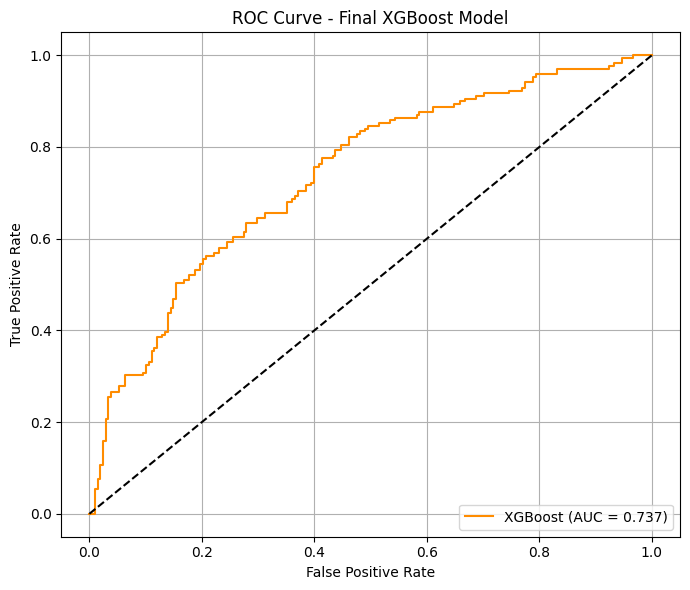

In [185]:
#### Final Model: Full XGBoost Model
final_model = optimal_xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.2, random_state=42, stratify=y)

import seaborn as sns

# Predict class labels and probabilities
y_pred_final = final_model.predict(X_test)
y_probs_final = final_model.predict_proba(X_test)[:, 1]

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix (Final XGBoost Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- 2. Classification Report ---
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

# --- 3. ROC Curve & AUC ---
fpr, tpr, _ = roc_curve(y_test, y_probs_final)
auc = roc_auc_score(y_test, y_probs_final)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.3f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion Section:

...